>> # Modelo preditivo - Melhor devedor
- Modelagem preditiva preditica de classificação binária para identificar o melhor telefone para discar eo devedor mais propenso a pagar um título

# Importando pacotes e bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os , gc, time, urllib, pyodbc, warnings
warnings.filterwarnings("ignore")
from datetime import date, timedelta
import sqlalchemy as sql
from sqlalchemy import create_engine

# ETL


In [5]:
params = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=xxxxxxxx;"
                                 "DATABASE=xxxxxxxxxx;" # trocar o nome da operação
                                 "UID=XXXXXXXXXX;"
                                 "PWD=XXXXXX;"
                                 "Trusted_Connection=no")
engine = sql.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params))
engine.connect

<bound method Engine.connect of Engine(mssql+pyodbc:///?odbc_connect=DRIVER%3D%7BSQL+Server+Native+Client+11.0%7D%3BSERVER%3D10.10.220.100%3BDATABASE%3DdbActyon_GAB%3BUID%3Dralisson.local%3BPWD%3DA4TIL%26fRplPn%3BTrusted_Connection%3Dno)>

In [6]:
#Criando variavei de datas para coleta da query sql

TODAY = date.today()
YESTERDAY = date.today() - timedelta(days=20)
data_inicio = f"{YESTERDAY.year}-{YESTERDAY.month}-{YESTERDAY.day}" #yesterday 
data_final = f"{TODAY.year}-{TODAY.month}-{TODAY.day}"

In [7]:
#Importando dados do banco de dados SQL

query = '''

    SELECT distinct
        tbtitulo.TITULO_ID,
        tbdevedor.CEP,
        tbdevedor_fone.ORIGEM,
        tbdevedor_fone.TIPO,
        tbdevedor.QTDE_TITULOS,
        tbdevedor.VALOR_DIVIDA_ATIVA,
        tbtitulo_contrato_indicador.INDICADOR,
        tbtitulo_pago.TIPO_BAIXA

    FROM tbtitulo  (NOLOCK)
        JOIN tbtitulo_pago  (NOLOCK) ON tbtitulo.TITULO_ID = tbtitulo_pago.TITULO_ID
        JOIN tbdevedor  (NOLOCK) ON tbdevedor.DEVEDOR_ID = tbtitulo.DEVEDOR_ID
        JOIN tbdevedor_fone  (NOLOCK) ON tbdevedor.DEVEDOR_ID = tbdevedor_fone.DEVEDOR_ID
        JOIN tbtitulo_contrato_indicador  (NOLOCK) ON tbdevedor.DEVEDOR_ID = tbtitulo_contrato_indicador.DEVEDOR_ID

    WHERE tbdevedor_fone.STATUS = 0
    AND tbdevedor.DATA_IMPORTACAO between
    

'''
#df = pd.read_sql(query, engine)
df = pd.read_sql(query + f"'{data_inicio}' AND '{data_final}'", engine)
print("tamanho da tabela: ", df.shape)

engine.dispose()
gc.collect()

tamanho da tabela:  (122815, 8)


0

In [8]:
df = df.drop_duplicates()
#df.dropna(inplace = True)
df.shape

(122815, 8)

# Engenharia de Atributos

In [9]:
#Trabalhando com datas
TODAY = date.today()
TODAY = pd.to_datetime(TODAY)

In [10]:
#alterando tipo das featrures
df['TIPO_BAIXA'] = df['TIPO_BAIXA'].astype('category')
df['CEP'] = df['CEP'].astype('category')
df['TITULO_ID'] = df['TITULO_ID'].astype(str)
df['ORIGEM'] = df['ORIGEM'].astype('category')
df['INDICADOR'] = df['INDICADOR'].astype('category')
df['TIPO'] = df['TIPO'].astype('category')

In [11]:
df.TIPO_BAIXA.value_counts()

0    90371
2    32444
Name: TIPO_BAIXA, dtype: int64

In [12]:
#Variavel alvo Pagamento de títulos
df['TARGET']  = df['TIPO_BAIXA'].replace(['1', '2' , '4','5', '3', '8','7',None, '0'], ['Nao_pagamento','Nao_pagamento', 'Nao_pagamento',
                                                                    'Nao_pagamento','Nao_pagamento','Nao_pagamento','Nao_pagamento','Nao_pagamento','Pagamento'])
df['TARGET']  = df['TARGET'].replace(['Nao_pagamento','Pagamento' ], [0, 1])

In [13]:
df.TARGET.value_counts()

1    90371
0    32444
Name: TARGET, dtype: int64

<AxesSubplot:>

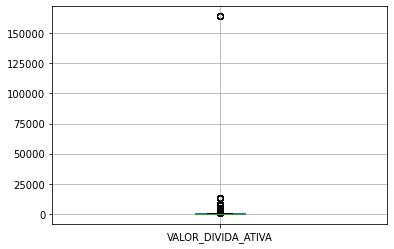

In [14]:
df.sample(frac=0.1).boxplot('VALOR_DIVIDA_ATIVA')

<AxesSubplot:>

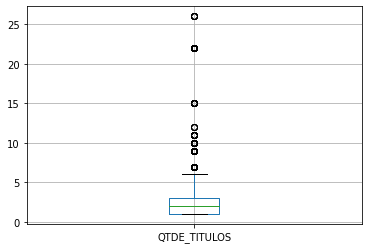

In [15]:
df.sample(frac=0.1).boxplot('QTDE_TITULOS')

In [20]:
df = df.query('VALOR_DIVIDA_ATIVA < 5000')
df = df.query('QTDE_TITULOS < 200 ')
df.shape

(103840, 9)

<AxesSubplot:>

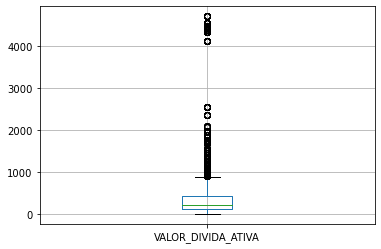

In [21]:
df.sample(frac=0.1).boxplot('VALOR_DIVIDA_ATIVA')

In [22]:
df.isna().sum()

TITULO_ID             0
CEP                   0
ORIGEM                0
TIPO                  0
QTDE_TITULOS          0
VALOR_DIVIDA_ATIVA    0
INDICADOR             0
TIPO_BAIXA            0
TARGET                0
dtype: int64

In [23]:
df.drop(columns=['TIPO_BAIXA'], inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.shape

(103840, 8)

# Pre Processamento dos dados

## Balanceamento de Variáveis

Class 0: 20378
Class 1: 83462
Proportion: 0.24 : 1


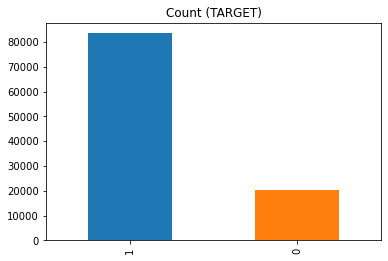

In [24]:
target_count = df['TARGET'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (TARGET)',color = ['#1F77B4', '#FF7F0E']);

Random under-sampling:
0    20378
1    20378
Name: TARGET, dtype: int64


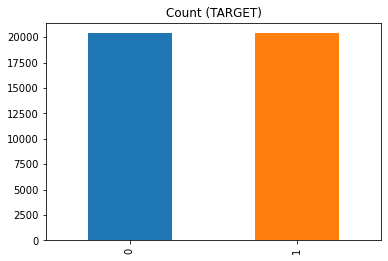

In [27]:
# CONTAR CLASSES
count_class_1, count_class_0 = df['TARGET'].value_counts()
# Divide by class
df_class_0 = df[df['TARGET'] == 0]
df_class_1 = df[df['TARGET'] == 1]
df_class_1_under = df_class_1.sample(count_class_0)
df = pd.concat([df_class_1_under, df_class_0], axis=0)
print('Random under-sampling:')
print(df['TARGET'].value_counts())
df['TARGET'].value_counts().plot(kind='bar', title='Count (TARGET)',color = ['#1F77B4', '#FF7F0E']);

In [28]:
df.columns

Index(['TITULO_ID', 'CEP', 'ORIGEM', 'TIPO', 'QTDE_TITULOS',
       'VALOR_DIVIDA_ATIVA', 'INDICADOR', 'TARGET'],
      dtype='object')

In [29]:
features = df[[ 'QTDE_TITULOS', 'VALOR_DIVIDA_ATIVA', 'CEP' , 'INDICADOR']] 

target = df[['TARGET']]

## Padronização ou Normalização das variáveis

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
features['CEP']= le.fit_transform(features["CEP"])
features['INDICADOR']= le.fit_transform(features["INDICADOR"])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features['QTDE_TITULOS'] = scaler.fit_transform(features[['QTDE_TITULOS']])
features['VALOR_DIVIDA_ATIVA'] = scaler.fit_transform(features[['VALOR_DIVIDA_ATIVA']])


In [31]:
del df_class_0
del df_class_1

# Modelagem preditiva

## Modelagem Preditiva com O algoritimo Devedor

In [32]:
# Avaliação do modelo usando o XGBoost
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

inicio = time.time()

# Divide os dados em treino e teste
X = features
Y = target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 5)

# Criando o modelo
Model = XGBClassifier(colsample_bytree=0.2, gamma=0, gpu_id=-1, learning_rate=0.2,  max_depth=6, n_estimators=150, n_jobs=48,
                         nthread=48, num_parallel_tree=1, random_state=0, subsample=0.2 ) 

# Treinando o modelo
Model.fit(X_train, Y_train)

# Previsão do modelo
Predict = Model.predict(X_test)
report = classification_report(Y_test, Predict)

# Imprimindo o relatório
print(report)

fim = time.time()
print("o tempo de execução foi de: ", fim - inicio, "segundos,  ou ",(fim - inicio)/60, "minutos" )

[09:33:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      6125
           1       0.97      0.81      0.88      6102

    accuracy                           0.89     12227
   macro avg       0.90      0.89      0.89     12227
weighted avg       0.90      0.89      0.89     12227

o tempo de execução foi de:  1.2158427238464355 segundos,  ou  0.020264045397440592 minutos


## Análise de Features e Acurácia

In [33]:
# Seleção dos melhores atributos como resultado para a modelagem CPC
gc.collect()
Model.feature_importances_
feature_importances = pd.DataFrame(Model.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances



,importance
QTDE_TITULOS,0.458767
VALOR_DIVIDA_ATIVA,0.322777
CEP,0.170824
INDICADOR,0.047631


In [35]:
# Salvando o modelo Propensao a pagar
import pickle

arquivo_cpf = './models/modelo_v1_devedor.sav'
pickle.dump(Model, open(arquivo_cpf, 'wb'))
print("Modelo salvo!")

# Salvar as features do modelo
with open('NameFeature_v1_devedor','wb') as arquivo_cpf:
   pickle.dump(features.columns, arquivo_cpf)

print('Nomes Salvo')

Modelo salvo!
Nomes Salvo
